In [9]:
# CFB Win Percentage Prediction Models

#  1) data loading and prep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os


data_path = 'data/team_stats_cleaned.csv'

try:
    df = pd.read_csv(data_path)
    print("data read successfully!")
    #print(df.head(1))
except FileNotFoundError:
    print("file could not be found")
    df = None

if df is not None:

    # starting with linear regression as a simple baseline

    print("\nExcluding data from the 2020 season due to potential outliers.")
    df_filtered = df[df['year'] != 2020].copy()
    print(f"Original DataFrame shape: {df.shape}")
    print(f"DataFrame shape (excluding 2020): {df_filtered.shape}\n")

# we now are splitting data into training and testing sets
sorted_unique_years = sorted(df_filtered['year'].unique())

train_years = sorted_unique_years[:-1]
test_years = sorted_unique_years[-1:]

print(f"Training on years: {train_years}.")
print(f"Testing on year: {test_years}.")

# create the test & training dataframes
train_df = df_filtered[df_filtered['year'].isin(train_years)].copy()
test_df = df_filtered[df_filtered['year'].isin(test_years)].copy()

# filter out the columns we don't need for training
cols_to_drop = ['team', 'year', 'wins', 'win_percentage', 'losses']
existing_cols_to_drop = [col for col in cols_to_drop if col in train_df.columns]

# need an X for features and a Y for target for both taining and testing data
Y_train = train_df['win_percentage']
Y_test = test_df['win_percentage']

X_train = train_df.drop(columns=cols_to_drop, errors='ignore')
X_test = test_df.drop(columns=cols_to_drop, errors='ignore')


data read successfully!

Excluding data from the 2020 season due to potential outliers.
Original DataFrame shape: (1172, 57)
DataFrame shape (excluding 2020): (1042, 57)

Training on years: [2016, 2017, 2018, 2019, 2021, 2022, 2023].
Testing on year: [2024].


In [10]:
# 2) feature scaling to ensure features are standardized (mean ~0, std ~1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# transform the test data using the same scaler but not fitting it
X_test_scaled = scaler.transform(X_test)




Predictions made on the test data.
First 5 actual Y_test values:
 1038    0.416667
1039    0.333333
1040    0.692308
1041    0.454545
1042    0.333333
Name: win_percentage, dtype: float64
First 5 predicted Y_pred values:
 [0.39533614 0.25020116 0.76073392 0.26636951 0.29483077]
Mean Absolute Error (MAE): 0.0636
Mean Squared Error (MSE): 0.0065
Root Mean Squared Error (RMSE): 0.0805
R-squared (R2): 0.8447

 Predictions vs. Actual


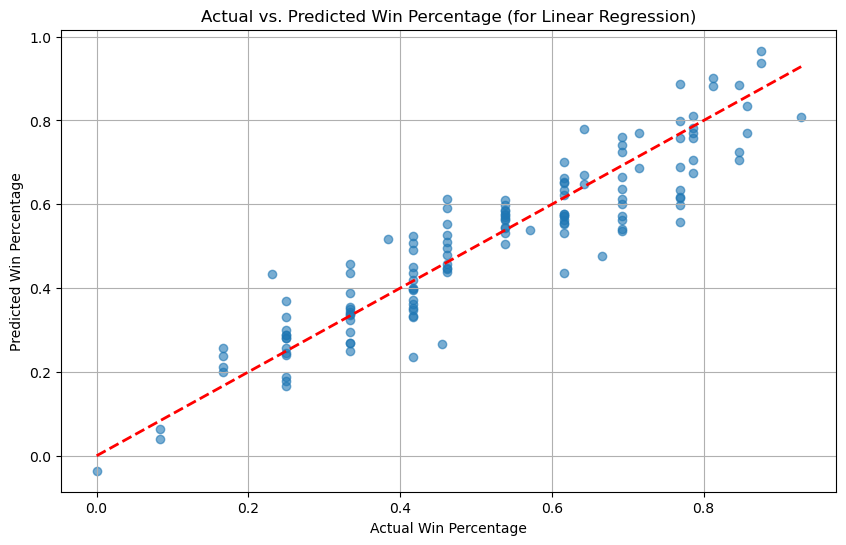


--- Ridge Regression Coefficients ---
                      Feature  Coefficient  Absolute_Coefficient
1     scoring_points_game_opp    -0.126376              0.126376
47    net_scoring_points_game     0.085620              0.085620
18          pass_attempts_opp     0.066533              0.066533
13            rushing_tds_opp     0.043994              0.043994
7          passing_rating_opp     0.040352              0.040352
41         redzone_scores_opp     0.035995              0.035995
19       pass_completions_opp    -0.034615              0.034615
12          rushing_yards_opp     0.031905              0.031905
6              passing_rating     0.031179              0.031179
40       redzone_attempts_opp    -0.030007              0.030007
3      avg_yards_per_play_opp    -0.026729              0.026729
21               pass_tds_opp     0.023632              0.023632
25  interceptions_returns_opp     0.023277              0.023277
42        time_possession_sec     0.015020         

In [11]:
# 3) ridge regression

# excessive multicollinearity, use Ridge linear regression model
model = Ridge(alpha=1.0)

# train the linear regression model
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("Predictions made on the test data.")
print("First 5 actual Y_test values:\n", Y_test.head(5))
print("First 5 predicted Y_pred values:\n", Y_pred[:5])

# model evaluation

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

print("\n Predictions vs. Actual")
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Win Percentage')
plt.ylabel('Predicted Win Percentage')
plt.title('Actual vs. Predicted Win Percentage (for Linear Regression)')
plt.grid(True)
plt.show()


# ridge model coefficients 
print("\n--- Ridge Regression Coefficients ---")
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
coefficients['Absolute_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)
print(coefficients)

In [12]:

# hyperparameter tuning and cross validation for ridge regression")

# different alphas to test
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

ridge = Ridge()

# use gridsearchcv to find the best hyperparameters for ridge regression, we want to minimize negative MSE
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled, Y_train)

print("\nBest parameters for Ridge Regression:", grid_search.best_params_)
print("Best negative MSE:", grid_search.best_score_)
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

best_ridge_model = grid_search.best_estimator_

# test this new best ridge model on the test data
Y_pred_best_ridge = best_ridge_model.predict(X_test_scaled)

# the results...
mae_best = mean_absolute_error(Y_test, Y_pred_best_ridge)
mse_best = mean_squared_error(Y_test, Y_pred_best_ridge)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(Y_test, Y_pred_best_ridge)

print(f"\n--- BEST Ridge Model Evaluation on Test Set ---")
print(f"MAE: {mae_best:.4f}")
print(f"MSE: {mse_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"R^2: {r2_best:.4f}")

# You can also re-examine the coefficients of this best model
print("\n--- Coefficients of the BEST Ridge Model ---")
coefficients_best = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': best_ridge_model.coef_})
coefficients_best['Absolute_Coefficient'] = np.abs(coefficients_best['Coefficient'])
coefficients_best = coefficients_best.sort_values(by='Absolute_Coefficient', ascending=False)
print(coefficients_best)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters for Ridge Regression: {'alpha': 1.0}
Best negative MSE: -0.005811809005871503
Best RMSE: 0.0762

--- BEST Ridge Model Evaluation on Test Set ---
MAE: 0.0636
MSE: 0.0065
RMSE: 0.0805
R^2: 0.8447

--- Coefficients of the BEST Ridge Model ---
                      Feature  Coefficient  Absolute_Coefficient
1     scoring_points_game_opp    -0.126376              0.126376
47    net_scoring_points_game     0.085620              0.085620
18          pass_attempts_opp     0.066533              0.066533
13            rushing_tds_opp     0.043994              0.043994
7          passing_rating_opp     0.040352              0.040352
41         redzone_scores_opp     0.035995              0.035995
19       pass_completions_opp    -0.034615              0.034615
12          rushing_yards_opp     0.031905              0.031905
6              passing_rating     0.031179              0.031179
40       redzone_attempts_opp    


--- Random Forest Model Evaluation on Test Set ---

MAE: 0.0673
MSE: 0.0069
RMSE: 0.0834
R^2: 0.8337

--- Random Forest Feature Importances ---
                     Feature  Importance
47   net_scoring_points_game    0.852524
18         pass_attempts_opp    0.012458
8           rushing_attempts    0.008611
6             passing_rating    0.005471
19      pass_completions_opp    0.004875
49  net_red_zone_success_pct    0.004040
23       interceptions_yards    0.003657
1    scoring_points_game_opp    0.003468
51       net_penalties_yards    0.003464
11      rushing_attempts_opp    0.003445


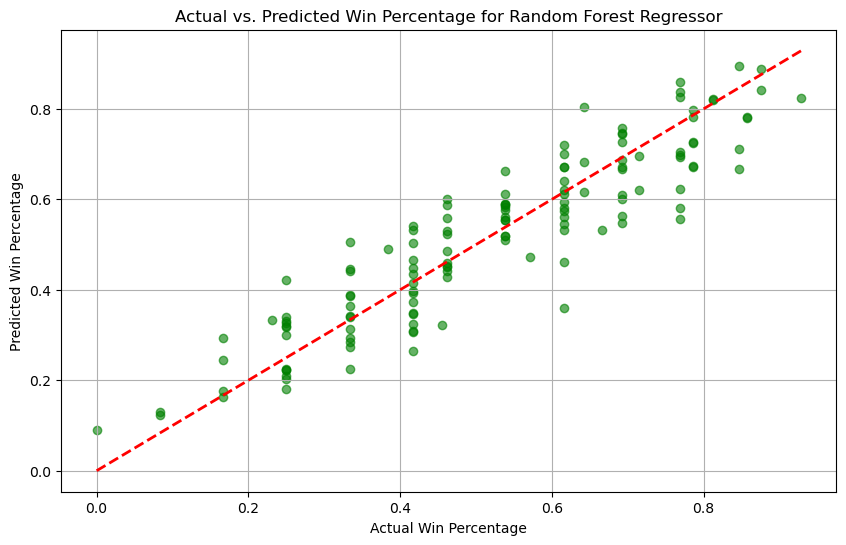

In [13]:
# 4) random forest regression

# 100 tress to start
randomforest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# train the model
randomforest_model.fit(X_train_scaled, Y_train)

# make our predictions
Y_pred_rf = randomforest_model.predict(X_test_scaled)

# mae, mse, rmse, r2
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf))
r2_rf = r2_score(Y_test, Y_pred_rf)

print(f"\n--- Random Forest Model Evaluation on Test Set ---\n")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R^2: {r2_rf:.4f}")

# list off feature importances
print("\n--- Random Forest Feature Importances ---")
feature_importances_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': randomforest_model.feature_importances_})
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)
print(feature_importances_rf.head(10))

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred_rf, alpha=0.6, color='green')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Win Percentage')
plt.ylabel('Predicted Win Percentage')
plt.title('Actual vs. Predicted Win Percentage for Random Forest Regressor')
plt.grid(True)
plt.show()


# seems like the ridge model did better wrt  MAE, RMSE, and R^2

In [14]:
# gradient boosting regressor